# 📊 VCGC vs SAHA-BELLETTI Flow
This is a draft to compare the performance on my proposed flow, VCGC, to the state-of-the-art flow, Saha-Belleti et al.
I would be comparing documenting and comparing the differences in the my proposed flow and the SOTA flow. 
VCGC is primarily based on the idea of using state-of-the-art logic synthesis and reversible circuit logic with a layered approach that opens room for optimizations.
Saha-Belletti et al. proposed flow is based on a monolothic architecture which uses invalid-color-detector and comparator oracles.   

## 📦 Packages
For the pupose of this research study, I independently developed and implemented the library for VCGC and repurposed the open-source code provided by [Analyzing, Fixing and Optimizing a Space-Efficient Quantum Circuit for the Graph K-Coloring Problem](https://github.com/Oscar-Belletti/Analyzing-Fixing-and-Optimizing-a-Space-Efficient-Quantum-Circuit-for-the-Graph-K-Coloring-Problem) by converting into a re-usable python library. _These libraries are essential in automating the synthesis of the circuits and generation of benchmark results._


### 1. Creating a Vertex Coloring Problem Network (VCP)
This will read from the DIMACS.col files which contain the benchamrks and parse it to be a VCPNetwork object which contains the metadata of the graph and a NetworkX representation of the graph. This will serve as the input to both of the libraries.

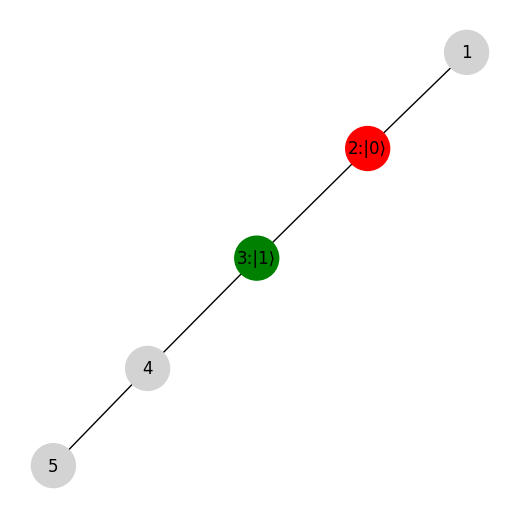

In [1]:
from vcgc.network import VCPNetwork

out_dir: str = "../data/vcgc_vs_saha_belletti/"
filename: str = "linear_2_colored"
dimacs_filename: str = "../data/benchmarks/" + filename + ".col"

network = VCPNetwork(file_path=dimacs_filename)

graph_filename: str = out_dir + filename + ".png"
with open(graph_filename,"w+") as f:
    f.close()
    
# Display the graph
network.draw_graph(name=graph_filename, node_size=1000) # Draw nice graph using NetworkX

### 2. Grover Circuit Synthesis using VCGC
This will prepare the complete grover's circuit using the VCGC library.

#### 2.1 Extract the graph constraints

In [2]:
from vcgc.boolean import BooleanFunction

# Create Boolean function and display the constraints 
bf: BooleanFunction  = BooleanFunction()
bf.print_vertex_constraints(network=network)

(v1 != v2) ∧ (v2 != v3) ∧ (v3 != v4) ∧ (v4 != v5)



#### 2.2 Generate the corresponding Logic Network

Verilog file written to: ../data/vcgc_vs_saha_belletti/linear_2_colored.v


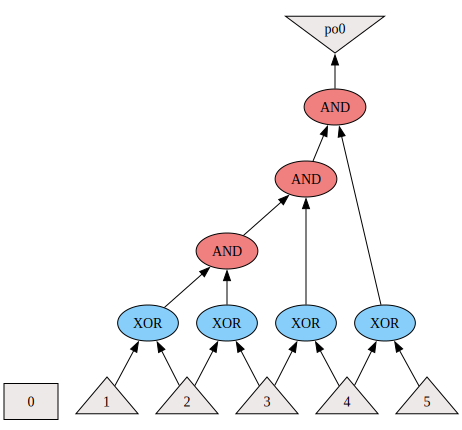

In [3]:
from tweedledum.bool_function_compiler.bool_function import BoolFunction
from tweedledum.classical import write_gate_dot, LogicNetwork
from graphviz import Source

# Generate tweedledum boolean function
tweedledum_bf: BoolFunction = bf.create_multi_bit_function(network=network)
logic_network: LogicNetwork = tweedledum_bf.logic_network()

# Write to Verilog
verilog_filename: str = out_dir + filename + ".v"
bf.write_verilog_file(network=network, filename=verilog_filename)

dot_filename: str = out_dir + filename + ".dot"

# Create a file with filename if it does not exist
with open(file=dot_filename, mode="w+") as f:
    f.close()

write_gate_dot(logic_network, dot_filename)

# Read and display the dot file
with open(dot_filename, 'r') as f:
    dot_content = f.read()

# Create and display the graph
graph = Source(dot_content)
# graph.view()  # This will open in external viewer
graph  # This will display inline in Jupyter notebook

#### 2.3 Set up XAG Synthesizer

In [4]:
from vcgc.synthesis import Synthesizer

synthesizer: Synthesizer = Synthesizer(cf=tweedledum_bf)

#### 2.4 Synthesize with XAG

In [5]:
from qiskit import QuantumCircuit

oracle_circuit_xag: QuantumCircuit = synthesizer.synthesize_with_xag()
# To output the circuit as ASCII art:
synthesizer.print_circuit_info()


Number of qubits: 8
                                                ╭────╮                    »
__a7 : ─────────────────────────────────────────┤ rx ├────────────────────»
                      ╭────╮                    ╰─┬──╯                    »
__a6 : ───────────────┤ rx ├──────────────────────●───────────────────────»
                      ╰─┬──╯                      │                       »
__q5 : ─────────────────┼─────────────────────────┼───────────────────────»
                        │                         │             ╭────────╮»
__q4 : ─────────────────┼─────────────────────────┼─────────────┤ parity ├»
                        │             ╭────────╮  │   ╭────────╮╰───┬────╯»
__q3 : ─────────────────┼─────────────┤ parity ├──●───┤ parity ├────●─────»
                        │             ╰───┬────╯      ╰───┬────╯          »
__q2 : ─────────●───────┼───────●─────────●───────────────●───────────────»
            ╭───┴────╮  │   ╭───┴────╮                              

#### 2.5 Display and Save the oracle circuit

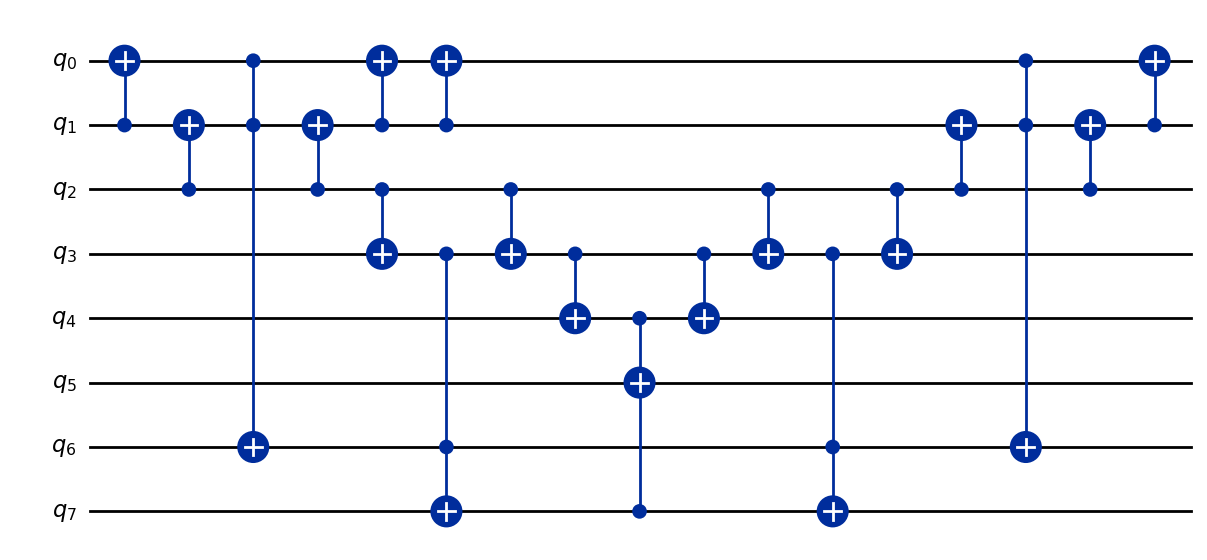

In [7]:
from qiskit.qasm3 import dump
qasm_filename: str = out_dir + filename + ".qasm"
with open(qasm_filename,"w") as f:
        dump(circuit=synthesizer.qiskit_circuit, stream=f)
oracle_circuit_xag.draw("mpl")